In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from tqdm import tqdm
import seaborn as sns

In [3]:
df=pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df=df.rename(columns={'year':'Year', 'aggregated_value':'count', 'country':'Mention_country', 'affiliation_country':'Aff_country'})
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP']
df=df[~df['subjarea'].isin(physical_sciences)]
df=df[df['Year'].isin(np.arange(2002, 2020))]
country_codes=pd.read_csv(r"C:\Users\Yasaman\Downloads\iso3.csv")
country_codes['iso3']=[c.lower() for c in country_codes['iso3']]
Map={country_codes.iloc[c]['iso3']: country_codes.iloc[c]['name'] for c in range(len(country_codes))}
Map['irn']='Iran'
Map['usa']='USA'
Map['gbr']='UK'
Map['syr']='Syria'

In [4]:
df1 = df.groupby(['Mention_country', 'Year'])['count'].sum().reset_index()
df2 = df.groupby(['Year'])['count'].sum().reset_index().rename(columns={'count': 'total_count'})
merged_df = df1.merge(df2, how='outer', on=['Year']).fillna(0).rename(columns={'Year':'year', 'Mention_country':'countrycode'})
merged_df['share']=merged_df['count']/merged_df['total_count']


In [16]:
Unrest_times = {
        'Egypt': [(2011, 2014)], 'Tunisia': [(2010.5, 2012)], 'Yemen': [(2011, 2019)], 'Syria': [(2011, 2019)],
        'Libya': [(2011, 2019)], 'Bahrain': [(2011, 2012)], 'Kuwait': [(2011, 2012)], 'Morocco': [(2011, 2012)],
        'Oman': [(2011, 2012)], 'Jordan': [(2011, 2012)]
    }

In [14]:
def plot_time(df, column, column_name,ax, log=True, show_mean=True, y_to_show=None, legend_to_show=True,show_dates=True):
      List=[['egy','tun'], ['lby', 'syr', 'yem'],  [ 'bhr', 'jor', 'kwt', 'mar', 'omn']]
      mean_df=df.groupby('year')[column].mean().reset_index()
      median_df=df.groupby('year')[column].median().reset_index()
      Q25_df=df.groupby('year')[column].quantile(.25).reset_index()
      Q75_df=df.groupby('year')[column].quantile(.75).reset_index()
      NC=0
      for k, country_list in enumerate(List):
        NB=0
        if show_mean:
          ax[k].plot(mean_df['year'].round(),mean_df[column],linestyle=':', color='k')
        ax[k].plot(median_df['year'].round(),median_df[column],linestyle='--', color='k')
        ax[k].fill_between(median_df['year'].round(),Q25_df[column],Q75_df[column], color='grey', alpha=0.2)
        markers=['o', 'v', '^', 'x', 's', 'd', '>', '<', 'p', '+']
        for country  in country_list:
          filt_df=df[df['countrycode']==country]
          #print(filt_df)
          if legend_to_show:
              ax[k].plot(filt_df['year'].round(),filt_df[column], label=rev_Country_list[country.upper()],color=f'C{NC}', marker=markers[NC], markersize=4)
          else:
            ax[k].plot(filt_df['year'].round(),filt_df[column],color=f'C{NC}', marker=markers[NC], markersize=4)
          NC+=1
          if country=='egy':
                color='C0'

          elif country =='tun':
            color='C1'

          else:
            color='yellow'
          NB+=1
          
          if NB<=2 and color!='yellow':
              for spans in Unrest_times[rev_Country_list[country.upper()]]:
                    start, end=spans
                    if not legend_to_show:
                        ax[k].axvspan(start, end, alpha=0.2, color=color, label=f'Unrest {rev_Country_list[country.upper()]}')
                    else:
                        ax[k].axvspan(start, end, alpha=0.2, color=color)

          elif NB==len(country_list) and color=='yellow':
             for spans in Unrest_times[rev_Country_list[country.upper()]]:
                    start, end=spans
                    if not legend_to_show:
                        ax[k].axvspan(start, end, alpha=0.2, color=color, label=f'Unrest period')
                    else:
                        ax[k].axvspan(start, end, alpha=0.2, color=color)
                        


      for axes in ax:

        axes.legend(loc='upper left', frameon=False)
        if y_to_show:
          axes.axhline(y_to_show,linestyle='-', color='cyan' )

        if not show_dates:
            axes.set_xticks(np.arange(2002, 2020 ),[' ' for i in np.arange(2002, 2020 )] )
        else:
            axes.set_xticks(np.arange(2002, 2020 ),[str(tick) if i % 4 == 0 else '' for i, tick in enumerate(np.arange(2002, 2020 ))])
        axes.set_xlabel('Year', fontsize=12)
        axes.set_xlim(2001.5, 2019.5)
        if log:
          axes.set_yscale('log')
        

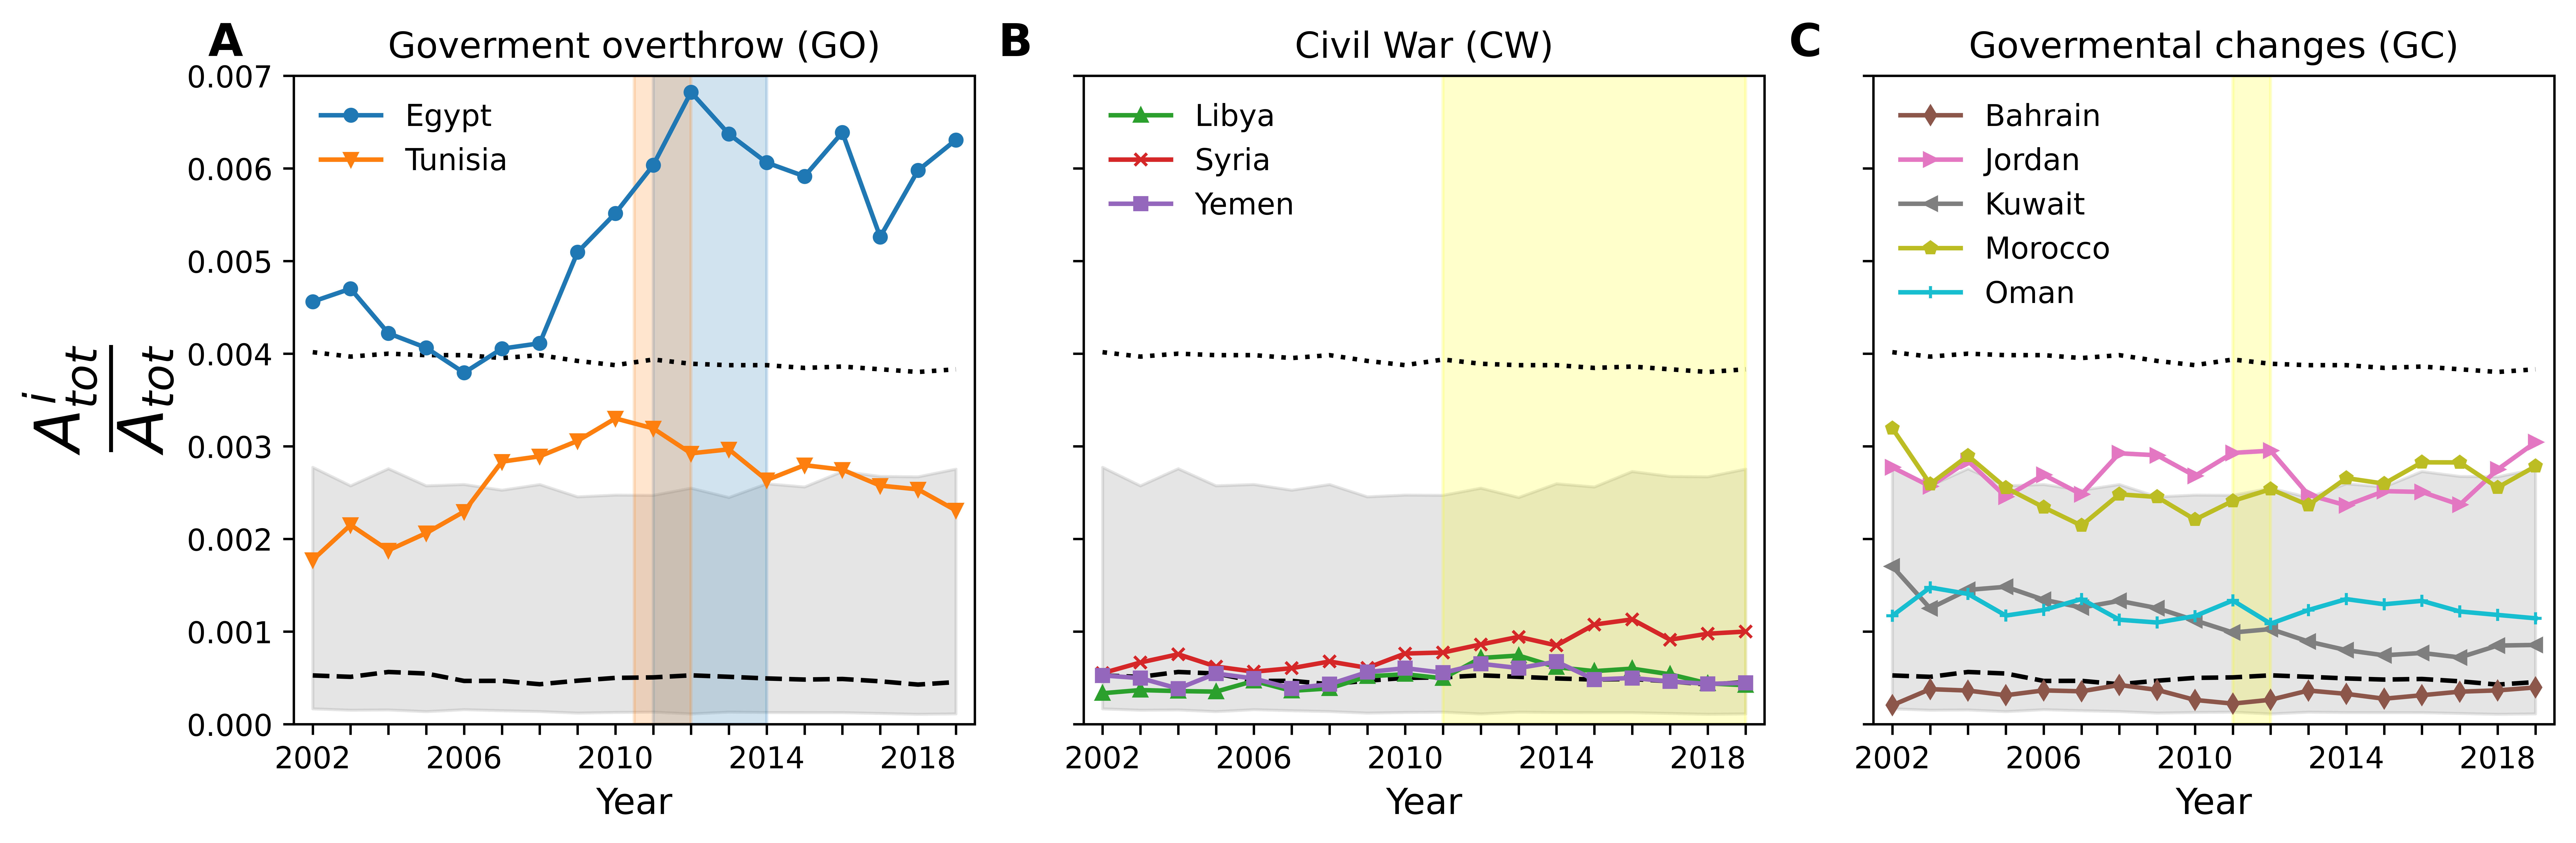

In [21]:
fig, axes=plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=1000)
axes=axes.flat
plot_time(merged_df, 'share', r'$\frac{TA_i^t}{\sum_i TA_i^t}$', log=False, show_mean=True, ax=axes,legend_to_show=True)

axes[0].set_ylim(0, 0.007)
axes[1].set_ylim(0, 0.007)
axes[2].set_ylim(0, 0.007)
axes[0].set_title('Goverment overthrow (GO)')
axes[1].set_title('Civil War (CW)')
axes[2].set_title('Govermental changes (GC)')
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

axes[0].set_ylabel(r'$\dfrac{A^i_{tot}}{A_{tot}}$', fontsize=21)
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes, fontsize=15, fontweight='bold', va='center', ha='center')
axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes, fontsize=15, fontweight='bold', va='center', ha='center')
axes[2].text(-0.1, 1.05, 'C', transform=axes[2].transAxes, fontsize=15, fontweight='bold', va='center', ha='center')

fig.tight_layout()
fig.savefig('Share_attention.pdf')